Optical chirality #3
=========================================
*03/2021: updated to pyGDM v1.1+*


In this example, we reproduce the near-field chirality close to a asymmetric silver from *Meinzer et al.* [1].

[1]: Meinzer et al.: *Probing the chiral nature of electromagnetic fields surrounding plasmonic nanostructures* **Phys. Rev. B** 88(4), 041407 (2013) (https://doi.org/10.1103/PhysRevB.88.041407)

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 288/288 dipoles valid
structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 288/288 dipoles valid
structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 288/288 dipoles valid


/home/hans/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


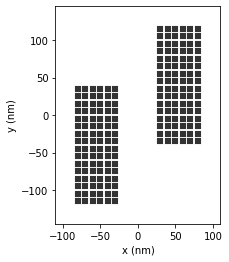

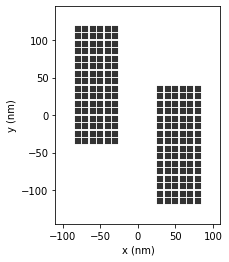

In [1]:
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2 import core
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import propagators
from pyGDM2 import visu

import numpy as np
import matplotlib.pyplot as plt




## --- Setup geometries of single rods
mesh = 'cube'
step = 10
W = 160.
L = 60.
H = 30
L_step = int(L/step)
W_step = int(W/step)
H_step = int(H/step)

geometry1 = structures.rect_wire(step, L=L_step, W=W_step, H=H_step, mesh=mesh, ORIENTATION=2)
geometry2 = structures.rect_wire(step, L=L_step, W=W_step, H=H_step, mesh=mesh, ORIENTATION=2)
geometry3 = structures.rect_wire(step, L=L_step, W=W_step, H=H_step, mesh=mesh, ORIENTATION=2)

geometry2.T[0] += 110
geometry3.T[0] += 110
geometry2.T[1] += 80
geometry3.T[1] -= 80

material = materials.silver()

struct1 = structures.struct(step, geometry1, material)
struct2 = structures.struct(step, geometry2, material)
struct3 = structures.struct(step, geometry3, material)


## --- Setup incident field
field_generator = fields.plane_wave
kwargs = dict(inc_angle=180, E_s=1, E_p=0)  # from bottom: inc_angle=0, from top: 180

wavelengths = np.linspace(500,1000, 31)
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

## --- environment: vacuum
n1, n2, n3 = 1.0, 1.0, 1.0
spacing = 300
dyads = propagators.DyadsQuasistatic123(n1, n2, n3, spacing)

## setup 3 simulations, for the fixed and for the moving blocks
sim1 = core.simulation(struct1, efield, dyads)
sim2 = core.simulation(struct2, efield, dyads)
sim3 = core.simulation(struct3, efield, dyads)


## combine the blocks for L-handed and R-handed dimer
c_sim_L = tools.combine_simulations([sim1, sim2])
c_sim_L = structures.center_struct(c_sim_L)

c_sim_R = tools.combine_simulations([sim1, sim3])
c_sim_R = structures.center_struct(c_sim_R)


visu.structure(c_sim_L)
visu.structure(c_sim_R)

running the simulation
--------------------------------

Now we run the simulations for the left and the right handed dimer.

In [2]:
#==============================================================================
# run the simulations
#==============================================================================
core.scatter(c_sim_L, verbose=True)
core.scatter(c_sim_R, verbose=True)

timing for wl=500.00nm - setup: EE 1524.7ms, inv.: 163.6ms, repropa.: 458.8ms (1 field configs), tot: 2147.2ms
timing for wl=516.67nm - setup: EE 27.8ms, inv.: 103.4ms, repropa.: 20.8ms (1 field configs), tot: 152.3ms
timing for wl=533.33nm - setup: EE 30.8ms, inv.: 118.9ms, repropa.: 20.5ms (1 field configs), tot: 170.4ms
timing for wl=550.00nm - setup: EE 29.8ms, inv.: 130.1ms, repropa.: 20.8ms (1 field configs), tot: 180.9ms
timing for wl=566.67nm - setup: EE 29.7ms, inv.: 107.9ms, repropa.: 20.9ms (1 field configs), tot: 158.6ms
timing for wl=583.33nm - setup: EE 29.7ms, inv.: 140.8ms, repropa.: 20.8ms (1 field configs), tot: 191.5ms
timing for wl=600.00nm - setup: EE 32.8ms, inv.: 113.1ms, repropa.: 20.3ms (1 field configs), tot: 166.4ms
timing for wl=616.67nm - setup: EE 33.0ms, inv.: 149.5ms, repropa.: 20.3ms (1 field configs), tot: 203.0ms
timing for wl=633.33nm - setup: EE 31.8ms, inv.: 141.7ms, repropa.: 19.9ms (1 field configs), tot: 193.5ms
timing for wl=650.00nm - setup: E

1

Plot the nano-sphere results
--------------------------------------------

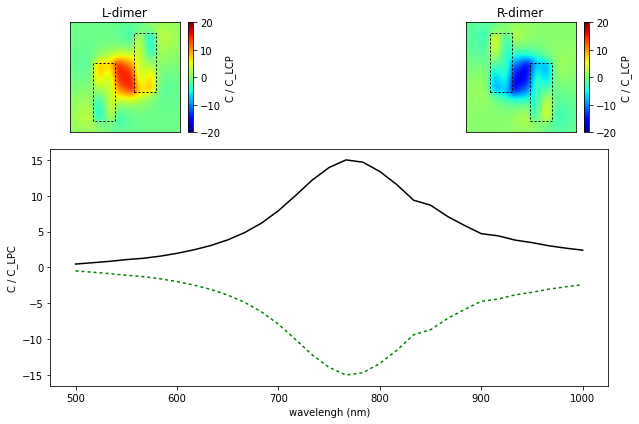

In [3]:
## --- calculate the C spectrum at top of the center between rods
Z_probe = c_sim_L.struct.geometry.T[2].max() + step/2 + 15

## L-dimer
wl, Cspec = tools.calculate_spectrum(c_sim_L, 0, linear.optical_chirality, r_probe=[[0,0,Z_probe]])
C_spec_R = Cspec.T

## R-dimer
wl, Cspec = tools.calculate_spectrum(c_sim_R, 0, linear.optical_chirality, r_probe=[[0,0,Z_probe]])
C_spec_L = Cspec.T



## --- C-mappings at peak (~770nm)
fieldindex = tools.get_closest_field_index(c_sim_R, dict(wavelength=770))

r_probe = tools.generate_NF_map(-150,+150,51, -150,150,51, Z0=Z_probe)

C_R = linear.optical_chirality(c_sim_R, fieldindex, r_probe, which_field='t')
C_L = linear.optical_chirality(c_sim_L, fieldindex, r_probe, which_field='t')



## --- plot
plt.figure(figsize=(9,6))

plt.subplot2grid((3,3), (0,0), aspect='equal')
plt.title("L-dimer")
im = visu.scalarfield(C_L, cmap='jet', show=0)
plt.colorbar(im, label='C / C_LCP')
im.set_clim(-20, 20)
visu.structure_contour(c_sim_L, color='k', dashes=[2,2], show=0)
plt.xticks([]); plt.yticks([])

plt.subplot2grid((3,3), (0,2), aspect='equal')
plt.title("R-dimer")
im = visu.scalarfield(C_R, cmap='jet', show=0)
plt.colorbar(im, label='C / C_LCP')
im.set_clim(-20, 20)
visu.structure_contour(c_sim_R, color='k', dashes=[2,2], show=0)
plt.xticks([]); plt.yticks([])


plt.subplot2grid((3,1), (1,0), rowspan=2, aspect='auto')
# plt.title("R-dimer")
plt.plot(wl, C_spec_R, color='k', label='L-struct')
plt.plot(wl, C_spec_L, color='g', dashes=[2,2], label='R-struct')
plt.xlabel("wavelengh (nm)")
plt.ylabel("C / C_LPC")


plt.tight_layout()
plt.show()